## Testando com mais tempo e mais dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import extractor as ext

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
base = pd.read_csv("./all_data_600ms.csv")
del base[base.columns[0]]
base.head()

,class,SENSOR0_RMS,SENSOR0_WAVELEN,SENSOR0_WAMP,SENSOR0_APPEN,SENSOR0_SAMPEN,SENSOR0_MAV,SENSOR1_RMS,SENSOR1_WAVELEN,SENSOR1_WAMP,...,SENSOR2_WAMP,SENSOR2_APPEN,SENSOR2_SAMPEN,SENSOR2_MAV,SENSOR3_RMS,SENSOR3_WAVELEN,SENSOR3_WAMP,SENSOR3_APPEN,SENSOR3_SAMPEN,SENSOR3_MAV
0,rest,0.029405,10.132518,350,0.774739,0.714504,0.021299,0.031459,12.459358,467,...,52,0.925832,0.824661,0.007794,0.006325,2.618580,20,0.743834,0.720893,0.004525
1,rest,0.338764,145.118427,1123,0.878671,0.851127,0.258561,0.291927,146.870687,1109,...,993,0.963864,0.962200,0.084331,0.010679,3.833016,59,0.719470,0.523739,0.007678
2,rest,0.021671,7.213547,213,0.759029,0.660268,0.015156,0.022970,7.044677,210,...,60,0.839379,0.676369,0.007350,0.022640,7.050325,207,0.522047,0.286833,0.012988
3,rest,0.052656,18.262196,633,0.766194,0.699608,0.037299,0.086512,52.839819,994,...,212,0.891606,0.740163,0.013117,0.006153,2.143498,12,0.658940,0.559863,0.003998
4,rest,0.027199,9.609158,371,0.848054,0.820414,0.021310,0.030284,12.305054,460,...,81,1.045390,1.018652,0.009075,0.002165,1.073322,0,0.943854,0.961897,0.001745


In [3]:
def remove_outliers(ds, col):
    Q1 = ds[col].quantile(0.25)
    Q3 = ds[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return ds[(ds[col] >= lower_bound) & (ds[col] <= upper_bound)]

In [4]:
def get_score_and_accuracy(X, Y):
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=0.7,test_size=0.3)

    encoder = LabelEncoder()

    Y_train = encoder.fit_transform(Y_train)
    Y_test = encoder.transform(Y_test)

    model = KNeighborsClassifier()
    model.fit(X_train, Y_train)
    preds_valid = model.predict(X_test)

    dr = {} 
    dr['model'] = 'KNN'
    dr['MAE'] = mean_absolute_error(Y_test, preds_valid)
    dr['ACC'] = accuracy_score(Y_test, preds_valid)


    model = SVC(kernel='poly')
    model.fit(X_train, Y_train)
    preds_valid = model.predict(X_test)

    dr_svm = {} 
    dr_svm['model'] = 'SVM'
    dr_svm['MAE'] = mean_absolute_error(Y_test, preds_valid)
    dr_svm['ACC'] = accuracy_score(Y_test, preds_valid)

    model = DecisionTreeClassifier()
    model.fit(X_train, Y_train)

    preds_valid = model.predict(X_test)

    dr_tree = {} 
    dr_tree['model'] = 'Tree Classifier'
    dr_tree['MAE'] = mean_absolute_error(Y_test, preds_valid)
    dr_tree['ACC'] = accuracy_score(Y_test, preds_valid)

    model = RandomForestClassifier()
    model.fit(X_train, Y_train)

    preds_valid = model.predict(X_test)

    dr_random = {} 
    dr_random['model'] = 'Random Forest'
    dr_random['MAE'] = mean_absolute_error(Y_test, preds_valid)
    dr_random['ACC'] = accuracy_score(Y_test, preds_valid)

    return pd.DataFrame([dr, dr_svm, dr_tree, dr_random])

In [5]:
labels = base['class'].unique()
labels

array(['rest', 'extension', 'flexion', 'ulnar_deviation',
       'radial_deviation', 'grip', 'finger_abduction', 'finger_adduction',
       'supination', 'pronation'], dtype=object)

## Exemplo de todas as classes com 4 sensores e RMS + outra feature

In [6]:
# RMS + APPEN
labels = base['class'].unique()
classes = labels

target_cols = 'class'
train_cols = ['SENSOR0_RMS', 'SENSOR1_RMS', 'SENSOR2_RMS', 'SENSOR3_RMS', 'SENSOR0_APPEN', 'SENSOR1_APPEN', 'SENSOR2_APPEN', 'SENSOR3_APPEN']


new_bases = []
for i in classes:
    curr_base = base.loc[base['class'] == i]
    for col in train_cols:
        no_out = remove_outliers(curr_base, col)
        new_bases.append(no_out)

cleased_base = pd.concat(new_bases)

X = cleased_base[train_cols]
Y = cleased_base[target_cols]

get_score_and_accuracy(X, Y)

,model,MAE,ACC
0,KNN,0.155169,0.955918
1,SVM,3.227683,0.152965
2,Tree Classifier,0.005510,0.998898
3,Random Forest,0.005510,0.998898


# Testing with cross validation to see if data is not skewed

In [7]:
# RMS + APPEN
labels = base['class'].unique()
classes = labels

target_cols = 'class'
train_cols = ['SENSOR0_RMS', 'SENSOR1_RMS', 'SENSOR2_RMS', 'SENSOR3_RMS', 'SENSOR0_APPEN', 'SENSOR1_APPEN', 'SENSOR2_APPEN', 'SENSOR3_APPEN']


new_bases = []
for i in classes:
    curr_base = base.loc[base['class'] == i]
    for col in train_cols:
        no_out = remove_outliers(curr_base, col)
        new_bases.append(no_out)

cleased_base = pd.concat(new_bases)

X = cleased_base[train_cols]
Y = cleased_base[target_cols]

cross_val_score(KNeighborsClassifier(), X, Y, cv=5), cross_val_score(RandomForestClassifier(), X, Y, cv=5)

(array([1.        , 1.        , 1.        , 0.99669312, 0.99933862]),
 array([1., 1., 1., 1., 1.]))

## Testing Confusin Matrix

In [8]:
def get_score_and_accuracy_with_cfmx(X, Y, labels=None):
    cfmx_dict = {}
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=0.8,test_size=0.2)

    encoder = LabelEncoder()

    Y_train = encoder.fit_transform(Y_train)
    Y_test = encoder.transform(Y_test)

    model = KNeighborsClassifier()
    model.fit(X_train, Y_train)
    preds_valid = model.predict(X_test)

    dr = {} 
    dr['model'] = 'KNN'
    dr['MAE'] = mean_absolute_error(Y_test, preds_valid)
    dr['ACC'] = accuracy_score(Y_test, preds_valid)

    y_true = encoder.inverse_transform(Y_test)
    y_pred = encoder.inverse_transform(preds_valid)
    cfmx_dict['KNN'] = confusion_matrix(y_true, y_pred, labels=labels)


    model = SVC()
    model.fit(X_train, Y_train)
    preds_valid = model.predict(X_test)

    dr_svm = {} 
    dr_svm['model'] = 'SVM'
    dr_svm['MAE'] = mean_absolute_error(Y_test, preds_valid)
    dr_svm['ACC'] = accuracy_score(Y_test, preds_valid)

    y_true = encoder.inverse_transform(Y_test)
    y_pred = encoder.inverse_transform(preds_valid)
    cfmx_dict['SVM'] = confusion_matrix(y_true, y_pred, labels=labels)

    model = DecisionTreeClassifier()
    model.fit(X_train, Y_train)

    preds_valid = model.predict(X_test)

    dr_tree = {} 
    dr_tree['model'] = 'Tree Classifier'
    dr_tree['MAE'] = mean_absolute_error(Y_test, preds_valid)
    dr_tree['ACC'] = accuracy_score(Y_test, preds_valid)

    y_true = encoder.inverse_transform(Y_test)
    y_pred = encoder.inverse_transform(preds_valid)
    cfmx_dict['Tree Classifier'] = confusion_matrix(y_true, y_pred, labels=labels)

    model = RandomForestClassifier()
    model.fit(X_train, Y_train)

    preds_valid = model.predict(X_test)

    dr_random = {} 
    dr_random['model'] = 'Random Forest'
    dr_random['MAE'] = mean_absolute_error(Y_test, preds_valid)
    dr_random['ACC'] = accuracy_score(Y_test, preds_valid)

    y_true = encoder.inverse_transform(Y_test)
    y_pred = encoder.inverse_transform(preds_valid)
    cfmx_dict['Random Forest'] = confusion_matrix(y_true, y_pred, labels=labels)

    return pd.DataFrame([dr, dr_svm, dr_tree, dr_random]), cfmx_dict

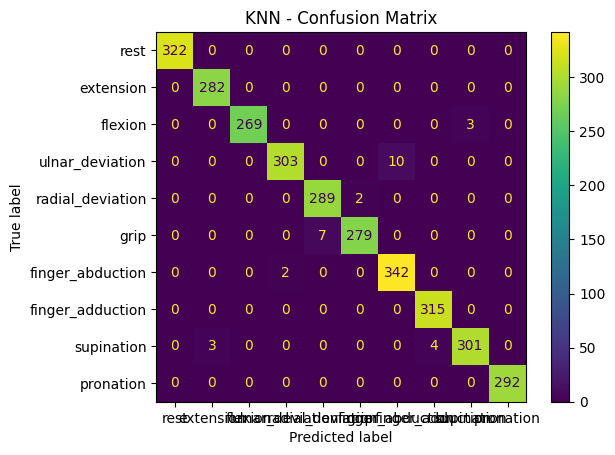

In [9]:
# RMS + APPEN
labels = base['class'].unique()
classes = labels

target_cols = 'class'
train_cols = ['SENSOR0_RMS', 'SENSOR1_RMS', 'SENSOR2_RMS', 'SENSOR3_RMS', 'SENSOR0_APPEN', 'SENSOR1_APPEN', 'SENSOR2_APPEN', 'SENSOR3_APPEN']


new_bases = []
for i in classes:
    curr_base = base.loc[base['class'] == i]
    for col in train_cols:
        no_out = remove_outliers(curr_base, col)
        new_bases.append(no_out)

cleased_base = pd.concat(new_bases)

X = cleased_base[train_cols]
Y = cleased_base[target_cols]

result, cfmx = get_score_and_accuracy_with_cfmx(X, Y)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title("KNN - Confusion Matrix")

ConfusionMatrixDisplay(cfmx['KNN'], display_labels=labels).plot(ax=ax)

In [25]:
def get_statistics_and_model(X, Y):
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=0.7,test_size=0.3)

    encoder = LabelEncoder()

    Y_train = encoder.fit_transform(Y_train)
    Y_test = encoder.transform(Y_test)

    model_knn = KNeighborsClassifier()
    model_knn.fit(X_train, Y_train)
    preds_valid = model_knn.predict(X_test)

    dr = {} 
    dr['model'] = 'KNN'
    dr['MAE'] = mean_absolute_error(Y_test, preds_valid)
    dr['ACC'] = accuracy_score(Y_test, preds_valid)


    model_svc = SVC(kernel='poly')
    model_svc.fit(X_train, Y_train)
    preds_valid = model_svc.predict(X_test)

    dr_svm = {} 
    dr_svm['model'] = 'SVM'
    dr_svm['MAE'] = mean_absolute_error(Y_test, preds_valid)
    dr_svm['ACC'] = accuracy_score(Y_test, preds_valid)

    model_decision_tree = DecisionTreeClassifier()
    model_decision_tree.fit(X_train, Y_train)

    preds_valid = model_decision_tree.predict(X_test)

    dr_tree = {} 
    dr_tree['model'] = 'Tree Classifier'
    dr_tree['MAE'] = mean_absolute_error(Y_test, preds_valid)
    dr_tree['ACC'] = accuracy_score(Y_test, preds_valid)

    model_random_forest = RandomForestClassifier()
    model_random_forest.fit(X_train, Y_train)

    preds_valid = model_random_forest.predict(X_test)

    dr_random = {} 
    dr_random['model'] = 'Random Forest'
    dr_random['MAE'] = mean_absolute_error(Y_test, preds_valid)
    dr_random['ACC'] = accuracy_score(Y_test, preds_valid)

    print('Encoder classes:', encoder.classes_)
    return pd.DataFrame([dr, dr_svm, dr_tree, dr_random]), model_knn, model_svc, model_decision_tree, model_random_forest

In [26]:
# RMS + APPEN
labels = base['class'].unique()
classes = labels

target_cols = 'class'
train_cols = ['SENSOR0_RMS', 'SENSOR1_RMS', 'SENSOR2_RMS', 'SENSOR3_RMS', 'SENSOR0_APPEN', 'SENSOR1_APPEN', 'SENSOR2_APPEN', 'SENSOR3_APPEN']


new_bases = []
for i in classes:
    curr_base = base.loc[base['class'] == i]
    for col in train_cols:
        no_out = remove_outliers(curr_base, col)
        new_bases.append(no_out)

cleased_base = pd.concat(new_bases)

X = cleased_base[train_cols]
Y = cleased_base[target_cols]

(statistics, knn_model, svc_model, decision_model, forest_model) = get_statistics_and_model(X, Y)
statistics

Encoder classes: ['extension' 'finger_abduction' 'finger_adduction' 'flexion' 'grip'
 'pronation' 'radial_deviation' 'rest' 'supination' 'ulnar_deviation']


,model,MAE,ACC
0,KNN,0.172581,0.952391
1,SVM,3.109985,0.139520
2,Tree Classifier,0.001102,0.998898
3,Random Forest,0.001102,0.998898


In [13]:
import pickle
with open("knn_model.pkl", 'wb') as f:
    pickle.dump(knn_model, f)

with open("svc_model.pkl", 'wb') as f:
    pickle.dump(svc_model, f)

with open("decision_model.pkl", 'wb') as f:
    pickle.dump(decision_model, f)

with open("forest_model.pkl", 'wb') as f:
    pickle.dump(forest_model, f)

In [19]:
cleased_base[[*train_cols, target_cols]].to_csv('cleased_base.csv')

In [59]:
cleased_base['class'].value_counts()

class
extension           1526
flexion             1523
grip                1520
finger_adduction    1518
pronation           1512
radial_deviation    1511
supination          1506
rest                1505
ulnar_deviation     1502
finger_abduction    1499
Name: count, dtype: int64

In [71]:
import numpy as np
index_choices = np.random.choice(cleased_base.index, 300)
selected = cleased_base.loc[index_choices]
selected['class'].unique()

array(['finger_abduction', 'rest', 'flexion', 'ulnar_deviation', 'grip',
       'extension', 'supination', 'radial_deviation', 'finger_adduction',
       'pronation'], dtype=object)

In [74]:
selected.to_csv('random_selected_test_rows.csv')
